In [1]:
from src.picasso.Picasso import Picasso
import numpy as np
import matplotlib.pyplot as plt
import anndata

## Package versions

In [2]:
np.__version__

'1.21.0'

In [3]:
anndata.__version__

'0.8.0'

In [4]:
import matplotlib; matplotlib.__version__

'3.4.2'

### Code snippet from `CP_2023/notebooks/picassoAnalysis_Fig7/uteroPicassoAnalysis.ipynb`

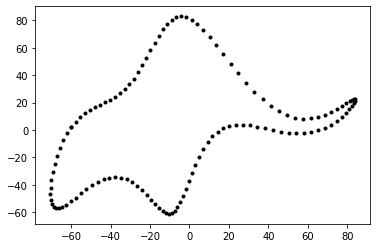

In [5]:
# elephant parameters -- see https://www.johndcook.com/blog/2011/06/21/how-to-fit-an-elephant/ --
batch_size = 128

p1, p2, p3, p4 = (50 - 30j, 18 +  8j, 12 - 10j, -14 - 60j )
p5 = 40 + 20j # eyepiece

def fourier(t, C):
    f = np.zeros(t.shape)
    A, B = C.real, C.imag
    for k in range(len(C)):
        f = f + A[k]*np.cos(k*t) + B[k]*np.sin(k*t)
    return f

def elephant(t, p1, p2, p3, p4, p5):
    npar = 6
    Cx = np.zeros((npar,), dtype='complex')
    Cy = np.zeros((npar,), dtype='complex')

    Cx[1] = p1.real*1j
    Cx[2] = p2.real*1j
    Cx[3] = p3.real
    Cx[5] = p4.real

    Cy[1] = p4.imag + p1.imag*1j
    Cy[2] = p2.imag*1j
    Cy[3] = p3.imag*1j

    x = fourier(t,Cx)
    y = fourier(t,Cy)

    return x,y

x, y = elephant(np.linspace(0,2*np.pi,batch_size), p1, p2, p3, p4, p5)

#Make array input for dimension of shape

y = y
x = x

coords = np.array([list(y),list(-x)])

plt.plot(y,-x,'.',c='black')
plt.show()


In [6]:
adata_exut=anndata.read_h5ad("../results/embeddings/exut_adata_standard_embeddings.h5ad")
adata_sim=anndata.read_h5ad("../results/embeddings/exut-sim-theta-10-real-seqdepths_adata_standard_embeddings.h5ad")
adata_merfish=anndata.read_h5ad("../results/embeddings/merfish_adata_standard_embeddings.h5ad")
adata_smartseq=anndata.read_h5ad("../results/embeddings/smartseq_adata_standard_embeddings.h5ad")
adata_mnist=anndata.read_h5ad("../results/embeddings/mnist_adata_standard_embeddings.h5ad")
datasets=[adata_exut,adata_merfish,adata_smartseq,adata_mnist,adata_sim]

In [ ]:
epochs = 500

for ad in datasets:

    dataset=ad.uns['dataset']
    seeds = ad.uns['seeds']
    
    #compute for scaled and unscaled data for main datasets
    if dataset in ['exut','merfish','smartseq']:
        use_scaled_modes = [False, True]
        print('running on scaled and unscaled data for', dataset)
        
    #only use unscaled for additional datasets
    else:
        use_scaled_modes = [False]
        print('running only on unscaled data for', dataset)
        
    for use_scaled in use_scaled_modes:
        
        if use_scaled:
            x_hd = ad.layers['X_scaled']
            scaled_str = '_scaled'
        else:
            x_hd = ad.X
            scaled_str = ''        
    
        #Run Picasso
        for seed in seeds:

            print(dataset, 'seed:', seed, 'scaled:', use_scaled)
            
            
            #fit
            picasso = Picasso(seed=seed,n_latent = 2, epochs = epochs, batch_size = batch_size)
            losses, x_elephant = picasso.fit(x_hd, coords, silent=False,ret_loss=True)
            
            
            #save
            ad.obsm[f'x{scaled_str}_elephant_seed_{seed}'] = x_elephant
            ad.uns[f'loss_x{scaled_str}_elephant_seed_{seed}'] = losses
            id_str = f'seed_{seed}_epochs_{epochs}'
            np.save(f'../results/embeddings/npy/{dataset}_x{scaled_str}_elephant_losses_{id_str}.npy',losses,allow_pickle=False)
            np.save(f'../results/embeddings/npy/{dataset}_x{scaled_str}_elephant_{id_str}.npy',x_elephant,allow_pickle=False)
            
            
            #plot
            plt.figure(figsize=(20,5))
            plt.subplot(141)  
            plt.plot(losses[:,0])
            plt.title('Boundary loss')
            plt.subplot(142)    
            plt.plot(losses[:,1])
            plt.title('Reconstruction loss')
            plt.subplot(143)    
            plt.plot(losses[:,2])
            plt.title('Total loss')
            plt.subplot(144)    
            plt.scatter(*x_elephant.T,s=3,lw=0)
            plt.gca().axis('off')
            plt.gca().set_aspect('equal')
            plt.show()
    
    ad.uns[f'params_elephant'] = dict(epochs=epochs)
    ad.write_h5ad(f"../results/embeddings/{dataset}_adata_all_embeddings.h5ad")